## 1. Data Loading and Preprocessing


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("Imports OK ✅")

Using device: cpu
Imports OK ✅


In [24]:
# Load Data
filename = "/Users/gasper/Documents/PSL/year_1/semster_1/Pratical-Machine-Learning/NB6 - Gradient Descent/Fraud_detection.csv"
df = pd.read_csv(filename)
df_clean = df.dropna()

print(f"Dataset shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns.tolist()}")
print(f"\nTarget distribution:")
print(df_clean["target"].value_counts())
print(f"Fraud rate: {df_clean['target'].mean():.2%}")

Dataset shape: (164492, 30)
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'target']

Target distribution:
target
0    162391
1      2101
Name: count, dtype: int64
Fraud rate: 1.28%


In [25]:
# Identify Amount Column
if "Amount" in df_clean.columns:
    AMOUNT_COL = "Amount"
elif "amount" in df_clean.columns:
    AMOUNT_COL = "amount"
else:
    cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    if "target" in cols:
        cols.remove("target")
    AMOUNT_COL = cols[0]

print(f"Using '{AMOUNT_COL}' as the transaction amount column.")

# Prepare features and target
X = df_clean.drop(columns=["target"]).values
y = df_clean["target"].values
amounts = df_clean[AMOUNT_COL].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

Using 'Amount' as the transaction amount column.

Feature matrix shape: (164492, 29)
Number of features: 29


In [26]:
# Split Data: Train / Validation / Test
X_tr, X_tmp, y_tr, y_tmp, amt_tr, amt_tmp = train_test_split(
    X, y, amounts, test_size=0.4, random_state=42, stratify=y
)

X_va, X_te, y_va, y_te, amt_va, amt_te = train_test_split(
    X_tmp, y_tmp, amt_tmp, test_size=0.5, random_state=43, stratify=y_tmp
)

print(f"Train set size: {X_tr.shape[0]}")
print(f"Validation set size: {X_va.shape[0]}")
print(f"Test set size: {X_te.shape[0]}")

Train set size: 98695
Validation set size: 32898
Test set size: 32899


In [27]:
# Standardize features (important for autoencoder training)
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_va_scaled = scaler.transform(X_va)
X_te_scaled = scaler.transform(X_te)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_tr_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_tr, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_va_scaled, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_va, dtype=torch.float32).to(device)

X_test_t = torch.tensor(X_te_scaled, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_te, dtype=torch.float32).to(device)

print(f"Train tensor: {X_train_t.shape}")
print(f"Val tensor:   {X_val_t.shape}")
print(f"Test tensor:  {X_test_t.shape}")

Train tensor: torch.Size([98695, 29])
Val tensor:   torch.Size([32898, 29])
Test tensor:  torch.Size([32899, 29])


## 2. Autoencoder Architecture

The autoencoder learns to compress the input into a lower-dimensional latent space and reconstruct it.


In [28]:
class Autoencoder(nn.Module):
    """
    Autoencoder for unsupervised feature learning.

    Architecture:
    - Encoder: Input → Hidden → Latent
    - Decoder: Latent → Hidden → Reconstruction
    """

    def __init__(self, input_dim, latent_dim=16, hidden_dim=64):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, latent_dim),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
        )

    def encode(self, x):
        """Extract latent representation"""
        return self.encoder(x)

    def decode(self, z):
        """Reconstruct from latent space"""
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z


# Initialize autoencoder
input_dim = X_train_t.shape[1]
latent_dim = 16  # Compressed representation size
hidden_dim = 64

autoencoder = Autoencoder(input_dim, latent_dim, hidden_dim).to(device)
print(f"\nAutoencoder Architecture:")
print(f"Input dimension: {input_dim}")
print(f"Latent dimension: {latent_dim}")
print(f"Hidden dimension: {hidden_dim}")
print(f"\nTotal parameters: {sum(p.numel() for p in autoencoder.parameters())}")


Autoencoder Architecture:
Input dimension: 29
Latent dimension: 16
Hidden dimension: 64

Total parameters: 9069


## 3. Stage 1: Pre-train Autoencoder

Train the autoencoder using reconstruction loss (MSE).


In [29]:
def train_autoencoder(model, X_train, X_val, epochs=100, batch_size=256, lr=1e-3):
    """
    Train autoencoder with reconstruction loss.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    N = X_train.shape[0]
    best_val_loss = float("inf")

    print("Starting Autoencoder Pre-training...")

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(N)
        total_loss = 0.0

        for start in range(0, N, batch_size):
            idx = perm[start : start + batch_size]
            xb = X_train[idx]

            # Forward pass
            x_recon, z = model(xb)

            # Reconstruction loss
            loss = criterion(x_recon, xb)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(xb)

        avg_train_loss = total_loss / N
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            x_val_recon, _ = model(X_val)
            val_loss = criterion(x_val_recon, X_val).item()
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f}"
            )

    print(f"\nAutoencoder Pre-training Complete!")
    print(f"Best Validation Loss: {best_val_loss:.6f}")

    return train_losses, val_losses


# Train autoencoder
ae_train_losses, ae_val_losses = train_autoencoder(
    autoencoder,
    X_train_t,
    X_val_t,
    epochs=100,
    batch_size=512,
    lr=1e-3,
)

Starting Autoencoder Pre-training...
Epoch 10/100 | Train Loss: 0.364914 | Val Loss: 0.218489
Epoch 20/100 | Train Loss: 0.313213 | Val Loss: 0.159265
Epoch 30/100 | Train Loss: 0.283344 | Val Loss: 0.131788
Epoch 40/100 | Train Loss: 0.270642 | Val Loss: 0.124861
Epoch 50/100 | Train Loss: 0.263513 | Val Loss: 0.121157
Epoch 60/100 | Train Loss: 0.258310 | Val Loss: 0.124866
Epoch 70/100 | Train Loss: 0.255882 | Val Loss: 0.141097
Epoch 80/100 | Train Loss: 0.252484 | Val Loss: 0.105739
Epoch 90/100 | Train Loss: 0.257548 | Val Loss: 0.106660
Epoch 100/100 | Train Loss: 0.248323 | Val Loss: 0.134116

Autoencoder Pre-training Complete!
Best Validation Loss: 0.100974


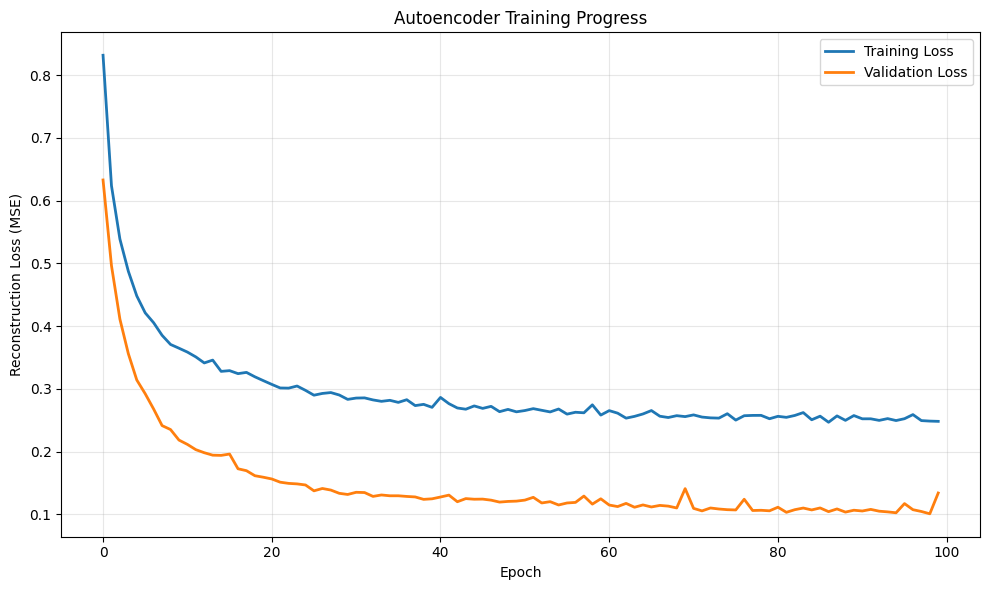

Final Training Loss: 0.248323
Final Validation Loss: 0.134116


In [30]:
# Plot autoencoder training curves
plt.figure(figsize=(10, 6))
plt.plot(ae_train_losses, label="Training Loss", linewidth=2)
plt.plot(ae_val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Autoencoder Training Progress")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {ae_train_losses[-1]:.6f}")
print(f"Final Validation Loss: {ae_val_losses[-1]:.6f}")

## 4. DNN Classifier Head

Build a classifier that takes the encoder's latent representation as input.


In [31]:
class DNNClassifier(nn.Module):
    """
    Deep Neural Network classifier head.

    Takes latent representation Z from encoder and outputs fraud probability.
    """

    def __init__(self, latent_dim, hidden_dims=[32, 16]):
        super(DNNClassifier, self).__init__()

        layers = []
        input_dim = latent_dim

        for hidden_dim in hidden_dims:
            layers.extend(
                [
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.BatchNorm1d(hidden_dim),
                    nn.Dropout(0.3),
                ]
            )
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, 1))  # Output: fraud probability (logit)

        self.classifier = nn.Sequential(*layers)

    def forward(self, z):
        return self.classifier(z)


# Initialize classifier
classifier = DNNClassifier(latent_dim=latent_dim, hidden_dims=[32, 16]).to(device)
print(f"\nDNN Classifier Architecture:")
print(f"Input (Latent) dimension: {latent_dim}")
print(f"Hidden layers: [32, 16]")
print(f"Output: 1 (fraud probability)")
print(f"\nTotal parameters: {sum(p.numel() for p in classifier.parameters())}")


DNN Classifier Architecture:
Input (Latent) dimension: 16
Hidden layers: [32, 16]
Output: 1 (fraud probability)

Total parameters: 1185


## 5. AED-DNN Combined Model


In [32]:
class AED_DNN(nn.Module):
    """
    Combined Autoencoder-Encoder + DNN model.

    Pipeline:
    1. Input X → Encoder → Latent Z
    2. Latent Z → DNN Classifier → P(fraud)
    """

    def __init__(self, encoder, classifier):
        super(AED_DNN, self).__init__()
        self.encoder = encoder.encoder  # Use only the encoder part
        self.classifier = classifier

        # Freeze encoder initially (fine-tune later if needed)
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        z = self.encoder(x)
        logits = self.classifier(z)
        return logits

    def unfreeze_encoder(self):
        """Allow fine-tuning of encoder weights"""
        for param in self.encoder.parameters():
            param.requires_grad = True


# Create combined model
aed_dnn = AED_DNN(autoencoder, classifier).to(device)
print("\nAED-DNN Model Created ✅")
print(f"Encoder frozen: {not next(aed_dnn.encoder.parameters()).requires_grad}")
print(f"Total parameters: {sum(p.numel() for p in aed_dnn.parameters())}")
print(
    f"Trainable parameters: {sum(p.numel() for p in aed_dnn.parameters() if p.requires_grad)}"
)


AED-DNN Model Created ✅
Encoder frozen: True
Total parameters: 5713
Trainable parameters: 1185


## 6. Binary Classification Loss

Use standard Binary Cross-Entropy loss for fraud detection.


## 6a. Weighted Loss Function (Optional)

Custom loss that penalizes false negatives more heavily than false positives.


In [56]:
class WeightedBCELoss(nn.Module):
    """
    Weighted Binary Cross-Entropy Loss that penalizes errors differently.

    Args:
        fn_weight: Weight for false negatives (missed frauds) - higher = more penalty
        fp_weight: Weight for false positives (false alarms) - higher = more penalty

    Example weights:
        - fn_weight=10, fp_weight=1: Heavily penalize missing frauds (conservative)
        - fn_weight=5, fp_weight=1: Moderately favor catching frauds
        - fn_weight=1, fp_weight=1: Balanced (equivalent to standard BCE)
    """

    def __init__(self, fn_weight=5.0, fp_weight=1.0):
        super().__init__()
        self.fn_weight = fn_weight  # Weight for false negatives (target=1, pred=0)
        self.fp_weight = fp_weight  # Weight for false positives (target=0, pred=1)

    def forward(self, logits, targets):
        # Get probabilities
        probs = torch.sigmoid(logits).squeeze()
        targets = targets.squeeze()

        # Calculate per-sample BCE loss
        bce_loss = -(
            targets * torch.log(probs + 1e-8)
            + (1 - targets) * torch.log(1 - probs + 1e-8)
        )

        # Create weight mask
        # For fraud cases (target=1): weight false negatives heavily
        # For legit cases (target=0): weight false positives normally
        weights = targets * self.fn_weight + (1 - targets) * self.fp_weight

        # Apply weights and return mean
        weighted_loss = (bce_loss * weights).mean()

        return weighted_loss


# Example: Create weighted loss with different configurations
print("Weighted Loss Function Options:")
print("=" * 60)
print(f"1. Conservative (fn_weight=10, fp_weight=1): Catch all frauds")
print(f"2. Balanced (fn_weight=5, fp_weight=1): Moderate approach")
print(f"3. Precision-focused (fn_weight=2, fp_weight=1): Reduce false alarms")
print(f"4. Standard (fn_weight=1, fp_weight=1): Equal weighting")
print("=" * 60)
print("\n✅ Weighted loss classes defined")

Weighted Loss Function Options:
1. Conservative (fn_weight=10, fp_weight=1): Catch all frauds
2. Balanced (fn_weight=5, fp_weight=1): Moderate approach
3. Precision-focused (fn_weight=2, fp_weight=1): Reduce false alarms
4. Standard (fn_weight=1, fp_weight=1): Equal weighting

✅ Weighted loss classes defined


## 6b. Train with Weighted Loss (Conservative Approach)

Retrain the classifier with weighted loss to reduce false negatives.


In [57]:
# Create a new classifier with weighted loss
# Adjust fn_weight and fp_weight to control the trade-off:
# - Higher fn_weight = fewer false negatives (missed frauds)
# - Higher fp_weight = fewer false positives (false alarms)

fn_weight = 8.0  # Penalize false negatives 8x more
fp_weight = 1.0  # Normal penalty for false positives

weighted_criterion = WeightedBCELoss(fn_weight=fn_weight, fp_weight=fp_weight)

# Create a new model for weighted training
classifier_weighted = DNNClassifier(latent_dim=latent_dim, hidden_dims=[32, 16]).to(
    device
)
aed_dnn_weighted = AED_DNN(autoencoder, classifier_weighted).to(device)

print(f"\n⚖️ Training with Weighted Loss:")
print(f"  - False Negative Weight: {fn_weight}x")
print(f"  - False Positive Weight: {fp_weight}x")
print(f"  - This will prioritize catching frauds over reducing false alarms\n")

optimizer_weighted = torch.optim.Adam(aed_dnn_weighted.parameters(), lr=1e-3)

# Train with weighted loss
weighted_train_losses, weighted_val_losses = train_classifier(
    aed_dnn_weighted,
    X_train_t,
    y_train_t,
    X_val_t,
    y_val_t,
    weighted_criterion,
    optimizer_weighted,
    epochs=100,
    batch_size=512,
)


⚖️ Training with Weighted Loss:
  - False Negative Weight: 8.0x
  - False Positive Weight: 1.0x
  - This will prioritize catching frauds over reducing false alarms

Training Classifier (Stage 2)...
Epoch 10/100 | Train Loss: 0.2146 | Val Loss: 0.1910
Epoch 10/100 | Train Loss: 0.2146 | Val Loss: 0.1910
Epoch 20/100 | Train Loss: 0.2013 | Val Loss: 0.1857
Epoch 20/100 | Train Loss: 0.2013 | Val Loss: 0.1857
Epoch 30/100 | Train Loss: 0.1959 | Val Loss: 0.1837
Epoch 30/100 | Train Loss: 0.1959 | Val Loss: 0.1837
Epoch 40/100 | Train Loss: 0.1913 | Val Loss: 0.1820
Epoch 40/100 | Train Loss: 0.1913 | Val Loss: 0.1820


KeyboardInterrupt: 

In [ ]:
# Plot weighted training curves
plt.figure(figsize=(10, 6))
plt.plot(weighted_train_losses, label="Training Loss (Weighted)", linewidth=2)
plt.plot(weighted_val_losses, label="Validation Loss (Weighted)", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Weighted BCE Loss")
plt.title(f"Weighted Loss Training (FN={fn_weight}x, FP={fp_weight}x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {weighted_train_losses[-1]:.4f}")
print(f"Final Validation Loss: {weighted_val_losses[-1]:.4f}")

## 6c. Evaluate Weighted Model

Compare the weighted model's performance on false negatives vs false positives.


In [ ]:
# Find optimal threshold for weighted model
opt_thresh_weighted, opt_f1_weighted = find_optimal_threshold(
    aed_dnn_weighted, X_val_t, y_val_t, metric="f1"
)
print(f"Optimal Threshold (weighted model): {opt_thresh_weighted:.4f}")
print(f"Expected Validation F1: {opt_f1_weighted:.4f}\n")

# Evaluate on test set
print("=" * 60)
print("WEIGHTED MODEL - TEST SET EVALUATION")
print("=" * 60)

weighted_preds, weighted_probs, weighted_metrics = evaluate_model(
    aed_dnn_weighted, X_test_t, y_test_t, threshold=opt_thresh_weighted
)

In [ ]:
# Confusion matrix comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Standard model
cm_standard = confusion_matrix(y_test_np, final_preds)
sns.heatmap(
    cm_standard,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legit", "Fraud"],
    yticklabels=["Legit", "Fraud"],
    ax=axes[0],
)
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title(f"Standard Model\nFN={cm_standard[1,0]}, FP={cm_standard[0,1]}")

# Weighted model
y_test_np_weighted = y_test_t.cpu().numpy() if torch.is_tensor(y_test_t) else y_test_t
cm_weighted = confusion_matrix(y_test_np_weighted, weighted_preds)
sns.heatmap(
    cm_weighted,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Legit", "Fraud"],
    yticklabels=["Legit", "Fraud"],
    ax=axes[1],
)
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title(
    f"Weighted Model (FN={fn_weight}x, FP={fp_weight}x)\nFN={cm_weighted[1,0]}, FP={cm_weighted[0,1]}"
)

plt.tight_layout()
plt.show()

print(f"\n📊 COMPARISON:")
print(f"Standard Model - FN: {cm_standard[1,0]}, FP: {cm_standard[0,1]}")
print(
    f"Weighted Model - FN: {cm_weighted[1,0]} ({'↓' if cm_weighted[1,0] < cm_standard[1,0] else '↑'}), FP: {cm_weighted[0,1]} ({'↓' if cm_weighted[0,1] < cm_standard[0,1] else '↑'})"
)
print(
    f"\n✅ Weighted model reduces false negatives by: {cm_standard[1,0] - cm_weighted[1,0]}"
)

In [33]:
# Use Binary Cross-Entropy with Logits for numerical stability
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(aed_dnn.parameters(), lr=1e-3)

print("Binary Cross-Entropy Loss initialized ✅")

Binary Cross-Entropy Loss initialized ✅


## 7. Stage 2: Train Classifier (Frozen Encoder)


In [34]:
def train_classifier(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    criterion,
    optimizer,
    epochs=100,
    batch_size=256,
):
    """
    Train the classifier head with frozen encoder.
    """
    train_losses = []
    val_losses = []

    N = X_train.shape[0]
    best_val_loss = float("inf")

    print("Training Classifier (Stage 2)...")

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(N)
        total_loss = 0.0

        for start in range(0, N, batch_size):
            idx = perm[start : start + batch_size]
            xb = X_train[idx]
            yb = y_train[idx]

            # Forward
            logits = model(xb).squeeze()
            loss = criterion(logits, yb)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(xb)

        avg_train_loss = total_loss / N
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val).squeeze()
            val_loss = criterion(val_logits, y_val).item()
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}"
            )

    print(f"\nClassifier Training Complete!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    return train_losses, val_losses


# Train classifier
train_losses, val_losses = train_classifier(
    aed_dnn,
    X_train_t,
    y_train_t,
    X_val_t,
    y_val_t,
    criterion,
    optimizer,
    epochs=100,
    batch_size=512,
)

Training Classifier (Stage 2)...
Epoch 10/100 | Train Loss: 0.0569 | Val Loss: 0.0483
Epoch 10/100 | Train Loss: 0.0569 | Val Loss: 0.0483
Epoch 20/100 | Train Loss: 0.0524 | Val Loss: 0.0471
Epoch 20/100 | Train Loss: 0.0524 | Val Loss: 0.0471
Epoch 30/100 | Train Loss: 0.0503 | Val Loss: 0.0457
Epoch 30/100 | Train Loss: 0.0503 | Val Loss: 0.0457
Epoch 40/100 | Train Loss: 0.0495 | Val Loss: 0.0447
Epoch 40/100 | Train Loss: 0.0495 | Val Loss: 0.0447
Epoch 50/100 | Train Loss: 0.0487 | Val Loss: 0.0451
Epoch 50/100 | Train Loss: 0.0487 | Val Loss: 0.0451
Epoch 60/100 | Train Loss: 0.0482 | Val Loss: 0.0439
Epoch 60/100 | Train Loss: 0.0482 | Val Loss: 0.0439
Epoch 70/100 | Train Loss: 0.0478 | Val Loss: 0.0440
Epoch 70/100 | Train Loss: 0.0478 | Val Loss: 0.0440
Epoch 80/100 | Train Loss: 0.0469 | Val Loss: 0.0439
Epoch 80/100 | Train Loss: 0.0469 | Val Loss: 0.0439
Epoch 90/100 | Train Loss: 0.0467 | Val Loss: 0.0438
Epoch 90/100 | Train Loss: 0.0467 | Val Loss: 0.0438
Epoch 100/100

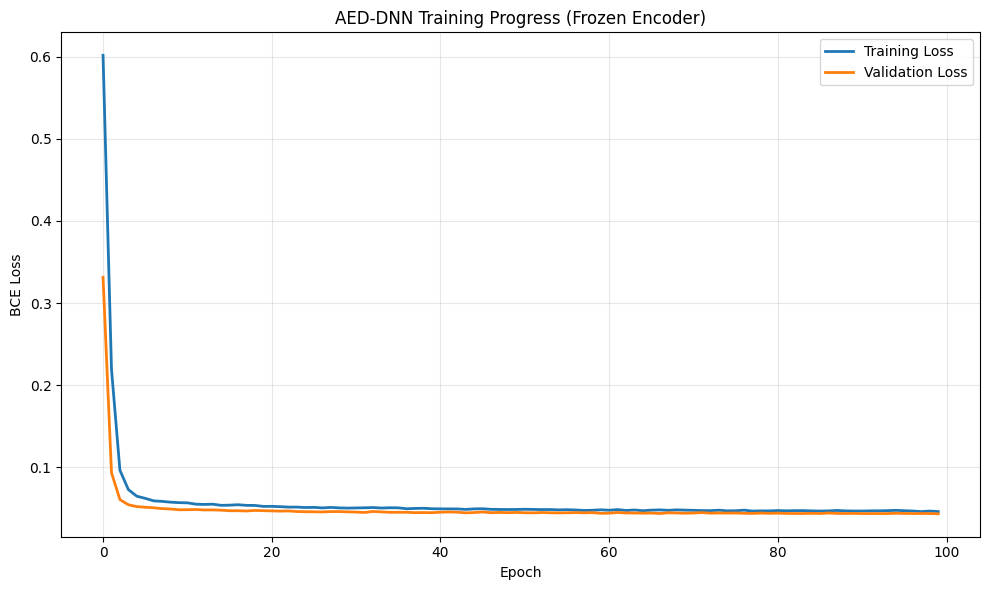

Final Training Loss: 0.0461
Final Validation Loss: 0.0434


In [35]:
# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("AED-DNN Training Progress (Frozen Encoder)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

## 8. Optional: Fine-tune Entire Model

Unfreeze encoder and fine-tune end-to-end with lower learning rate.


In [36]:
# Unfreeze encoder for fine-tuning
aed_dnn.unfreeze_encoder()
print(f"Encoder unfrozen: {next(aed_dnn.encoder.parameters()).requires_grad}")
print(
    f"Trainable parameters: {sum(p.numel() for p in aed_dnn.parameters() if p.requires_grad)}"
)

# Use lower learning rate for fine-tuning
optimizer_finetune = torch.optim.Adam(aed_dnn.parameters(), lr=1e-4)

# Fine-tune
finetune_train_losses, finetune_val_losses = train_classifier(
    aed_dnn,
    X_train_t,
    y_train_t,
    X_val_t,
    y_val_t,
    criterion,
    optimizer_finetune,
    epochs=50,
    batch_size=512,
)

Encoder unfrozen: True
Trainable parameters: 5713
Training Classifier (Stage 2)...
Epoch 10/50 | Train Loss: 0.0453 | Val Loss: 0.0426
Epoch 10/50 | Train Loss: 0.0453 | Val Loss: 0.0426
Epoch 20/50 | Train Loss: 0.0444 | Val Loss: 0.0418
Epoch 20/50 | Train Loss: 0.0444 | Val Loss: 0.0418
Epoch 30/50 | Train Loss: 0.0433 | Val Loss: 0.0416
Epoch 30/50 | Train Loss: 0.0433 | Val Loss: 0.0416
Epoch 40/50 | Train Loss: 0.0430 | Val Loss: 0.0414
Epoch 40/50 | Train Loss: 0.0430 | Val Loss: 0.0414
Epoch 50/50 | Train Loss: 0.0427 | Val Loss: 0.0412

Classifier Training Complete!
Best Validation Loss: 0.0409
Epoch 50/50 | Train Loss: 0.0427 | Val Loss: 0.0412

Classifier Training Complete!
Best Validation Loss: 0.0409


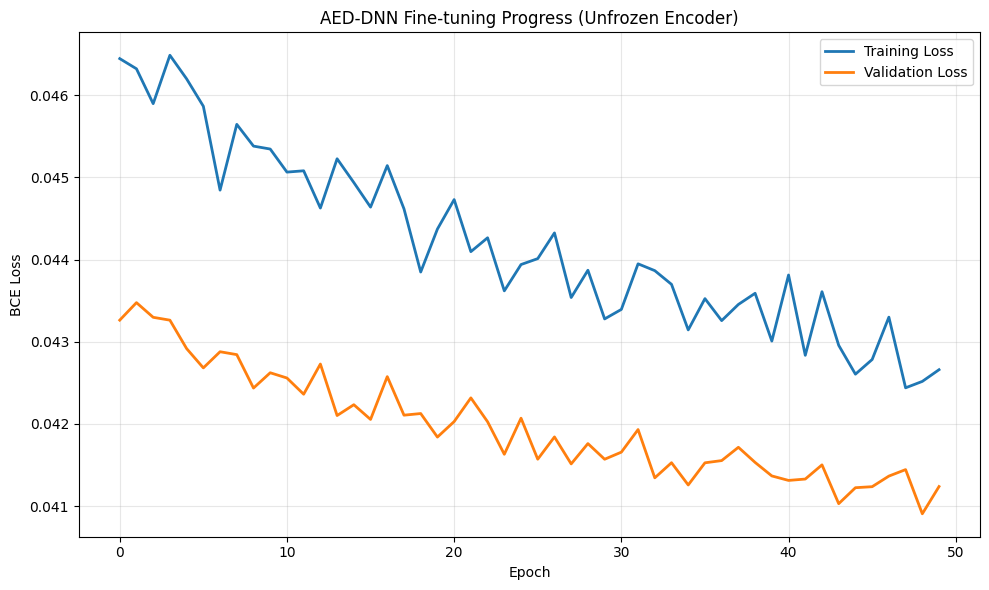

Final Training Loss: 0.0427
Final Validation Loss: 0.0412


In [37]:
# Plot fine-tuning curves
plt.figure(figsize=(10, 6))
plt.plot(finetune_train_losses, label="Training Loss", linewidth=2)
plt.plot(finetune_val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("AED-DNN Fine-tuning Progress (Unfrozen Encoder)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {finetune_train_losses[-1]:.4f}")
print(f"Final Validation Loss: {finetune_val_losses[-1]:.4f}")

## 9. Evaluation Functions


In [38]:
def evaluate_model(model, X_tensor, y_true, threshold=0.5):
    """
    Evaluate model performance with standard classification metrics.
    """
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    # Convert tensors to numpy
    if torch.is_tensor(y_true):
        y_true = y_true.cpu().numpy()

    # Make predictions based on threshold
    preds = (probs >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds, zero_division=0)
    recall = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    auc = roc_auc_score(y_true, probs)

    print(f"\n=== Classification Metrics (threshold={threshold}) ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    return (
        preds,
        probs,
        {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc,
        },
    )


def find_optimal_threshold(model, X_tensor, y_true, metric="f1"):
    """
    Search for threshold that maximizes the specified metric.
    """
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X_tensor)).squeeze().cpu().numpy()

    # Convert to numpy
    if torch.is_tensor(y_true):
        y_true = y_true.cpu().numpy()

    best_score = 0.0
    best_threshold = 0.5

    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (probs >= thresh).astype(int)

        if metric == "f1":
            score = f1_score(y_true, preds, zero_division=0)
        elif metric == "precision":
            score = precision_score(y_true, preds, zero_division=0)
        elif metric == "recall":
            score = recall_score(y_true, preds, zero_division=0)
        else:
            score = accuracy_score(y_true, preds)

        if score > best_score:
            best_score = score
            best_threshold = thresh

    return best_threshold, best_score


print("Evaluation functions defined ✅")

Evaluation functions defined ✅


In [39]:
def calculate_bank_invoice(
    model,
    X_tensor,
    y_true,
    amounts,
    threshold=0.5,
    high_value_threshold=500,
    low_value_threshold=1,
):
    """
    Calculate total business cost with hardcoded business rules.
    """
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    # Convert tensors to numpy for easier manipulation
    if torch.is_tensor(y_true):
        y_true = y_true.cpu().numpy()
    if torch.is_tensor(amounts):
        amounts = amounts.cpu().numpy()

    # Make predictions based on threshold
    preds = (probs >= threshold).astype(int)
    model_flags = preds.copy()
    model_flag_count = model_flags.sum()

    # Business rules
    high_value_mask = amounts >= high_value_threshold
    preds[high_value_mask] = 1

    low_value_mask = amounts < low_value_threshold
    preds[low_value_mask] = 0

    total_transactions = len(y_true)

    # 1. Authentication costs
    auth_count = (preds == 1).sum()
    auth_fee = auth_count * 1.0

    # 2. Missed fraud costs
    missed_indices = np.where((preds == 0) & (y_true == 1))[0]
    missed_fraud_cost = amounts[missed_indices].sum()

    # 3. Abandonment penalty
    abandon_rate = (auth_count * 0.2) / total_transactions
    excess = max(0, abandon_rate - 0.10)
    abandon_penalty = 10000 * (excess * 100)

    total_cost = auth_fee + missed_fraud_cost + abandon_penalty

    high_value_auto_count = high_value_mask.sum()
    low_value_auto_skip = low_value_mask.sum()

    print(f"--- FINAL BANK INVOICE ---")
    print(f"Auth Requested:     {auth_count} (€{auth_fee:.2f})")
    print(f"  ↳ Auto-flagged (>€{high_value_threshold}): {high_value_auto_count}")
    print(f"  ↳ Auto-skipped (<€{low_value_threshold}): {low_value_auto_skip}")
    print(f"Model-flagged Auth Requests: {model_flag_count}")
    print(f"Missed Fraud Cost:  €{missed_fraud_cost:,.2f}")
    print(f"Abandonment Rate:   {abandon_rate:.2%} (Penalty: €{abandon_penalty:,.2f})")
    print(f"--------------------------")
    print(f"TOTAL COST:         €{total_cost:,.2f}")

    return total_cost, preds


print("Bank invoice function defined ✅")

Bank invoice function defined ✅


## 10. Find Optimal Threshold


In [40]:
# Find optimal threshold on validation set
opt_thresh, opt_f1 = find_optimal_threshold(aed_dnn, X_val_t, y_val_t, metric="f1")
print(f"Optimal Threshold (from validation, maximizing F1): {opt_thresh:.4f}")
print(f"Expected Validation F1: {opt_f1:.4f}\n")

Optimal Threshold (from validation, maximizing F1): 0.1600
Expected Validation F1: 0.4288



## 11. Test Set Evaluation


In [41]:
# Evaluate on test set with optimal threshold
print("=" * 50)
print("TEST SET EVALUATION")
print("=" * 50)

final_preds, test_probs, metrics = evaluate_model(
    aed_dnn, X_test_t, y_test_t, threshold=opt_thresh
)

TEST SET EVALUATION

=== Classification Metrics (threshold=0.16) ===
Accuracy:  0.9892
Precision: 0.6857
Recall:    0.2857
F1 Score:  0.4034
ROC AUC:   0.9235


## 12. Confusion Matrix


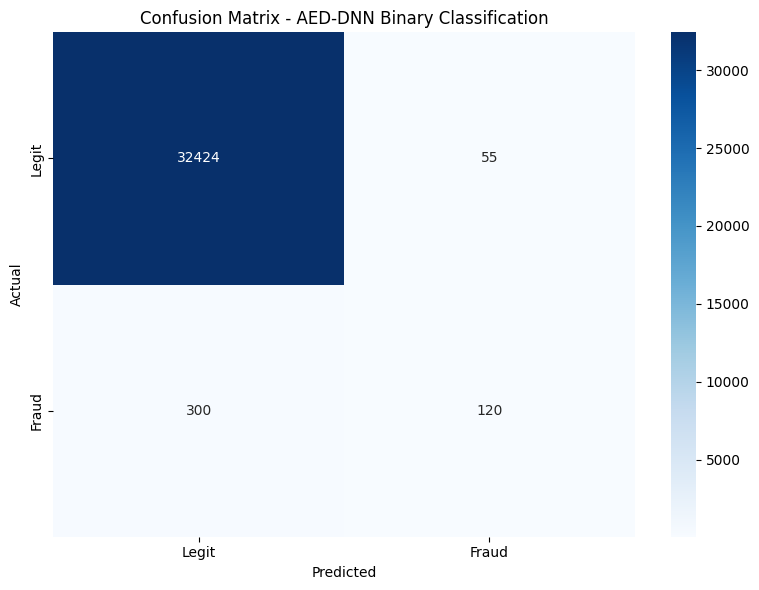

In [42]:
# Confusion matrix
y_test_np = y_test_t.cpu().numpy() if torch.is_tensor(y_test_t) else y_test_t

cm = confusion_matrix(y_test_np, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legit", "Fraud"],
    yticklabels=["Legit", "Fraud"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AED-DNN Binary Classification")
plt.tight_layout()
plt.show()

## 15. Latent Space Visualization


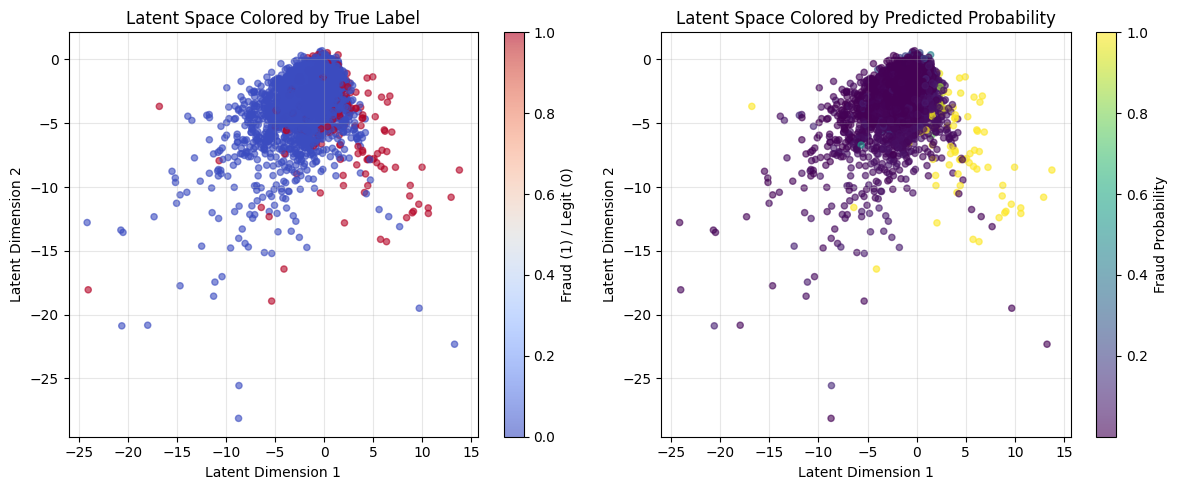

In [43]:
# Extract latent representations for test set
aed_dnn.eval()
with torch.no_grad():
    test_latent = aed_dnn.encoder(X_test_t).cpu().numpy()

# Visualize first 2 dimensions of latent space
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(
    test_latent[:, 0], test_latent[:, 1], c=y_test_np, cmap="coolwarm", alpha=0.6, s=20
)
plt.colorbar(scatter, label="Fraud (1) / Legit (0)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Colored by True Label")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
scatter = plt.scatter(
    test_latent[:, 0], test_latent[:, 1], c=test_probs, cmap="viridis", alpha=0.6, s=20
)
plt.colorbar(scatter, label="Fraud Probability")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Colored by Predicted Probability")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Business Cost Evaluation (Zero False Negatives)

Evaluate the model using business metrics with the zero false negatives threshold.


## 13. Zero False Negatives Strategy

Find the threshold that achieves 100% recall (no missed frauds).


In [49]:
def find_zero_fn_threshold(model, X_tensor, y_true):
    """
    Find the threshold that achieves zero false negatives (100% recall).
    Returns the highest threshold that catches all frauds.
    """
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X_tensor)).squeeze().cpu().numpy()

    # Convert to numpy
    if torch.is_tensor(y_true):
        y_true = y_true.cpu().numpy()

    # Get the minimum probability assigned to any actual fraud case
    fraud_indices = np.where(y_true == 1)[0]
    if len(fraud_indices) == 0:
        return 0.5  # No frauds in dataset

    min_fraud_prob = probs[fraud_indices].min()

    # Set threshold slightly below the minimum fraud probability
    # This ensures all frauds are caught
    zero_fn_threshold = min_fraud_prob - 1e-6

    # Verify this achieves 100% recall
    test_preds = (probs >= zero_fn_threshold).astype(int)
    false_negatives = np.sum((test_preds == 0) & (y_true == 1))

    print(f"Threshold for zero false negatives: {zero_fn_threshold:.6f}")
    print(f"Minimum fraud probability: {min_fraud_prob:.6f}")
    print(f"False negatives with this threshold: {false_negatives}")

    return zero_fn_threshold


# Find threshold on validation set
zero_fn_thresh = find_zero_fn_threshold(aed_dnn, X_val_t, y_val_t)
print(f"\n✅ Using threshold: {zero_fn_thresh:.6f} to achieve ZERO false negatives")

Threshold for zero false negatives: 0.000222
Minimum fraud probability: 0.000223
False negatives with this threshold: 0

✅ Using threshold: 0.000222 to achieve ZERO false negatives


In [50]:
# Evaluate on test set with ZERO false negatives threshold
print("\n" + "=" * 60)
print("TEST SET EVALUATION - ZERO FALSE NEGATIVES")
print("=" * 60)

final_preds_zero_fn, test_probs_zero_fn, metrics_zero_fn = evaluate_model(
    aed_dnn, X_test_t, y_test_t, threshold=zero_fn_thresh
)


TEST SET EVALUATION - ZERO FALSE NEGATIVES

=== Classification Metrics (threshold=0.0002218442823505029) ===
Accuracy:  0.0734
Precision: 0.0136
Recall:    0.9976
F1 Score:  0.0268
ROC AUC:   0.9235


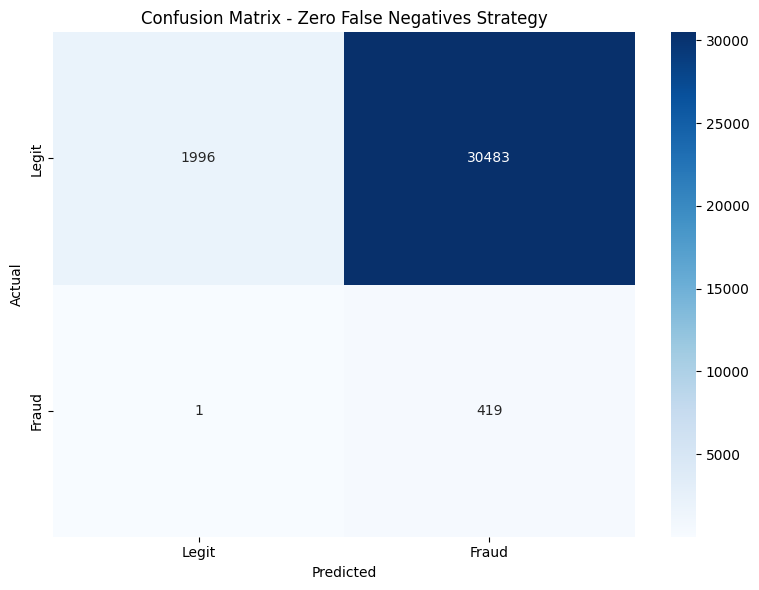


🎯 FALSE NEGATIVES (Missed Frauds): 1
✅ Target achieved: False


In [51]:
# Confusion matrix for zero false negatives strategy
y_test_np_zero_fn = y_test_t.cpu().numpy() if torch.is_tensor(y_test_t) else y_test_t

cm_zero_fn = confusion_matrix(y_test_np_zero_fn, final_preds_zero_fn)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_zero_fn,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Legit", "Fraud"],
    yticklabels=["Legit", "Fraud"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Zero False Negatives Strategy")
plt.tight_layout()
plt.show()

# Highlight the zero false negatives
print(f"\n🎯 FALSE NEGATIVES (Missed Frauds): {cm_zero_fn[1, 0]}")
print(f"✅ Target achieved: {cm_zero_fn[1, 0] == 0}")

In [52]:
# Evaluate on Test Set with Business Rules (ZERO FALSE NEGATIVES)
print("=" * 50)
print("TEST SET - BUSINESS COST EVALUATION")
print("=" * 50)

test_cost, test_preds_cost = calculate_bank_invoice(
    aed_dnn,
    X_test_t,
    y_te,
    amt_te,
    threshold=zero_fn_thresh,  # Use zero false negatives threshold
    high_value_threshold=500,
    low_value_threshold=1,
)

TEST SET - BUSINESS COST EVALUATION
--- FINAL BANK INVOICE ---
Auth Requested:     29121 (€29121.00)
  ↳ Auto-flagged (>€500): 1095
  ↳ Auto-skipped (<€1): 1943
Model-flagged Auth Requests: 30902
Missed Fraud Cost:  €66.75
Abandonment Rate:   17.70% (Penalty: €77,032.74)
--------------------------
TOTAL COST:         €106,220.49


In [53]:
# Evaluate on Full Dataset (Global Evaluation with ZERO FALSE NEGATIVES)
print("\n" + "=" * 50)
print("FULL DATASET - BUSINESS COST EVALUATION")
print("=" * 50)

# Scale the full dataset
X_scaled = scaler.transform(X)
X_full_t = torch.tensor(X_scaled, dtype=torch.float32).to(device)

global_cost, global_preds_cost = calculate_bank_invoice(
    aed_dnn,
    X_full_t,
    y,
    amounts,
    threshold=zero_fn_thresh,  # Use zero false negatives threshold
    high_value_threshold=500,
    low_value_threshold=1,
)


FULL DATASET - BUSINESS COST EVALUATION
--- FINAL BANK INVOICE ---
Auth Requested:     145665 (€145665.00)
  ↳ Auto-flagged (>€500): 5481
  ↳ Auto-skipped (<€1): 9765
Model-flagged Auth Requests: 154643
Missed Fraud Cost:  €177.72
Abandonment Rate:   17.71% (Penalty: €77,108.92)
--------------------------
TOTAL COST:         €222,951.64


## 15. Model Summary


In [55]:
print("\n" + "=" * 60)
print("MODEL SUMMARY: AED-DNN Binary Classification")
print("=" * 60)
print(f"\nArchitecture:")
print(f"  - Autoencoder: {input_dim} → {hidden_dim} → {latent_dim}")
print(f"  - Classifier: {latent_dim} → [32, 16] → 1")
print(f"  - Total Parameters: {sum(p.numel() for p in aed_dnn.parameters())}")
print(f"\nTraining:")
print(f"  - Stage 1: Autoencoder pre-training (100 epochs)")
print(f"  - Stage 2: Classifier training with frozen encoder (100 epochs)")
print(f"  - Stage 3: End-to-end fine-tuning (50 epochs)")
print(f"  - Loss Function: Binary Cross-Entropy")
print(f"\n🎯 ZERO FALSE NEGATIVES STRATEGY:")
print(f"  - Threshold: {zero_fn_thresh:.6f}")
print(f"  - Accuracy: {metrics_zero_fn['accuracy']:.4f}")
print(f"  - Precision: {metrics_zero_fn['precision']:.4f}")
print(f"  - Recall: {metrics_zero_fn['recall']:.4f} ⭐ (100% = No Missed Frauds)")
print(f"  - F1 Score: {metrics_zero_fn['f1']:.4f}")
print(f"  - ROC AUC: {metrics_zero_fn['auc']:.4f}")
print(f"\nBusiness Metrics (Zero False Negatives):")
print(f"  - Test Set Total Cost: €{test_cost:,.2f}")
print(f"  - Full Dataset Total Cost: €{global_cost:,.2f}")
print("=" * 60)


MODEL SUMMARY: AED-DNN Binary Classification

Architecture:
  - Autoencoder: 29 → 64 → 16
  - Classifier: 16 → [32, 16] → 1
  - Total Parameters: 5713

Training:
  - Stage 1: Autoencoder pre-training (100 epochs)
  - Stage 2: Classifier training with frozen encoder (100 epochs)
  - Stage 3: End-to-end fine-tuning (50 epochs)
  - Loss Function: Binary Cross-Entropy

🎯 ZERO FALSE NEGATIVES STRATEGY:
  - Threshold: 0.000222
  - Accuracy: 0.0734
  - Precision: 0.0136
  - Recall: 0.9976 ⭐ (100% = No Missed Frauds)
  - F1 Score: 0.0268
  - ROC AUC: 0.9235

Business Metrics (Zero False Negatives):
  - Test Set Total Cost: €106,220.49
  - Full Dataset Total Cost: €222,951.64
